# Cyclist Training






## Introduction

Pour commencer, récupérez les images de la base de données :


In [3]:
!git clone https://github.com/Kizyow/cyclist-ai-training.git

Cloning into 'cyclist-ai-training'...
remote: Enumerating objects: 3146, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 3146 (delta 25), reused 118 (delta 12), pack-reused 3014 (from 4)
Receiving objects: 100% (3146/3146), 821.27 MiB | 46.10 MiB/s, done.
Resolving deltas: 100% (88/88), done.


La base de données qui vous est fournie regroupe 4 classes :

1. Vélos seuls
2. Cycliste portant un casque
3. Cycliste ne portant pas de casque
4. Rien

In [4]:
import PIL
from PIL import Image
import csv
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam


## Préparation des données

Le code ci-dessous permet de charger les données et les formater pour la classification. Prenez le temps de regarder un peu le format des labels $y$.
Notez que les images sont rendues carrées lors du chargement.

In [7]:
# Lecture du CSV contenant les informations relatives à la base de données
dataset = []
with open('cyclist-ai-training/annotations.csv', newline='') as csvfile:
	filereader = csv.reader(csvfile, delimiter=' ', quotechar='|')
	for row in filereader:
		data = row[0].split(',')
		if data[0] != 'filename':
			xmin = float(data[2])
			ymin = float(data[3])
			xmax = float(data[4])
			ymax = float(data[5])
			size = float(256)
			box = [xmin, ymin, xmax, ymax]
			new_entry = {'type': data[1],'class': data[6], 'path': data[0], 'shape': [size, size], 'box': box}
			dataset.append(new_entry)

# Nombre de classes de la base de données et intitulé des classes
class_labels = list(dict.fromkeys([item['class'] for item in dataset]))
num_classes = len(class_labels)

dataset_train = [item for item in dataset if item['type']=='train']
dataset_test = [item for item in dataset if item['type']=='test']
dataset_val = [item for item in dataset if item['type']=='val']

print(class_labels)

['velo', 'velo_personne', 'velo_personne_casque', 'rien']


In [ ]:
# Pour générer un dataset avec un ensemble d'entrainement, de tests et de validation

import csv
from collections import defaultdict
import random

# Dictionary to store attributes for each filename
image_attributes = defaultdict(list)

# Read the CSV file
with open('cyclist-ai-training/annotations_formatted.csv', newline='') as csvfile:
    filereader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for row in filereader:
        data = row[0].split(',')
        if data[0] != 'filename':
            filename = data[0]
            xmin = float(data[1])
            ymin = float(data[2])
            width = float(data[3])
            height = float(data[4])
            xmax = xmin + width
            ymax = ymin + height
            attributes = [
                xmin,  # x
                ymin,  # y
                xmax,  # width
                ymax,  # height
                data[5]          # classe
            ]
            image_attributes[filename].append(attributes)

# Number of classes in the dataset and their labels
class_labels = list(dict.fromkeys([attr[4] for attributes_list in image_attributes.values() for attr in attributes_list]))
num_classes = len(class_labels)

print("\nClass labels:", class_labels)

# Calculer le nombre total d'images
total_images = len(image_attributes)

# Calculer le nombre d'images pour chaque ensemble
train_size = int(0.7 * total_images)
val_size = test_size = int(0.15 * total_images)

# Créer des listes pour stocker les images de chaque ensemble
train_images = []
val_images = []
test_images = []

# Mélanger les images pour une distribution aléatoire
all_images = list(image_attributes.keys())
random.shuffle(all_images)

# Remplir les ensembles
train_images = all_images[:train_size]
val_images = all_images[train_size:train_size + val_size]
test_images = all_images[train_size + val_size:]

# Créer les ensembles de données
train_set = {img: image_attributes[img] for img in train_images}
val_set = {img: image_attributes[img] for img in val_images}
test_set = {img: image_attributes[img] for img in test_images}

# Afficher les résultats
print("Ensemble d'entraînement :", train_set)
print("Ensemble de validation :", val_set)
print("Ensemble de test :", test_set)

from collections import Counter

# Fonction pour compter les classes dans un ensemble de données
def count_classes(dataset):
    class_counts = Counter()
    for image, boxes in dataset.items():
        for box in boxes:
            class_counts[box[-1]] += 1
    return class_counts

# Compter les classes dans chaque ensemble
train_class_distribution = count_classes(train_set)
val_class_distribution = count_classes(val_set)
test_class_distribution = count_classes(test_set)

# Afficher les distributions
print("Distribution des classes dans l'ensemble d'entraînement :", train_class_distribution)
print("Distribution des classes dans l'ensemble de validation :", val_class_distribution)
print("Distribution des classes dans l'ensemble de test :", test_class_distribution)

import csv

# Fonction pour convertir un ensemble de données en liste de dictionnaires
def dataset_to_csv_format(dataset, dataset_name):
    csv_data = []
    for filename, boxes in dataset.items():
        for box in boxes:
            csv_data.append({
                'filename': filename,
                'dataset': dataset_name,
                'x': box[0],
                'y': box[1],
                'width': box[2],
                'height': box[3],
                'classe': box[4]
            })
    return csv_data

# Convertir chaque ensemble de données
train_csv_data = dataset_to_csv_format(train_set, 'train')
val_csv_data = dataset_to_csv_format(val_set, 'val')
test_csv_data = dataset_to_csv_format(test_set, 'test')

# Fusionner toutes les données
all_csv_data = train_csv_data + val_csv_data + test_csv_data

# Écrire dans un fichier CSV
csv_filename = 'image_attributes.csv'
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=['filename', 'dataset', 'x', 'y', 'width', 'height', 'classe'])
    writer.writeheader()
    writer.writerows(all_csv_data)

print(f"Données exportées avec succès dans {csv_filename}")


Class labels: ['velo_personne_casque', 'velo_personne', 'rien', 'velo']


In [8]:
def build_localization_tensors(image_size, dataset, num_classes):
  # Préparation des structures de données pour x et y
  x = np.zeros((len(dataset), image_size, image_size, 3))
  y = np.empty((len(dataset), num_classes + 5)) # 1 + 4 + num_classes : présence / boîte englobante / classes

  # Compteur de parcours du dataset
  i = 0

  for item in dataset:
    # Lecture de l'image
    img = Image.open('cyclist-ai-training/images/' + item['path'])
    # Mise à l'échelle de l'image
    img = img.resize((image_size,image_size), Image.Resampling.LANCZOS)
    img = img.convert('RGB')
    # Remplissage de la variable x
    x[i] = np.asarray(img)

    y[i, 0] = 1 # Un objet est toujours présent !

    # Coordonnées de boîte englobante
    img_shape = item['shape']
    box = item['box']
    bx = (box[0] + (box[2] - box[0])/2)/img_shape[0]
    by = (box[1] + (box[3] - box[1])/2)/img_shape[1]
    bw = (box[2] - box[0])/img_shape[0]
    bh = (box[3] - box[1])/img_shape[1]
    y[i, 1] = bx
    y[i, 2] = by
    y[i, 3] = bw
    y[i, 4] = bh

    # Probabilités de classe, sous la forme d'une one-hot vector
    label = class_labels.index(item['class'])
    classes_probabilities = keras.utils.to_categorical(label, num_classes=num_classes)
    y[i, 5:] = classes_probabilities

    i = i+1

  return x, y


Séparation des données d'entraînement pour extraire un ensemble de validation, et pré-traitement des données.

In [10]:
# Pour la suite du TP on considèrera des images de taille 64x64x3
# Augmenter cette valeur donnerait de meilleurs résultats mais nécessiterait des calculs plus long.
IMAGE_SIZE = 128

# Lecture des données d'entraînement, de tests et de validations
x_train, y_train = build_localization_tensors(IMAGE_SIZE, dataset_train, num_classes)
x_test, y_test = build_localization_tensors(IMAGE_SIZE, dataset_test, num_classes)
x_val, y_val = build_localization_tensors(IMAGE_SIZE, dataset_val, num_classes)

# Pour améliorer l'entraînement, on peut centrer-réduire les coordonnées des bounding boxes...
y_std = np.std(y_train, axis=0)
y_mean = np.mean(y_train, axis=0)
y_train[...,1:5] = (y_train[...,1:5] - y_mean[1:5])/y_std[1:5]
y_val[...,1:5] = (y_val[...,1:5] - y_mean[1:5])/y_std[1:5]
y_test[...,1:5] = (y_test[...,1:5] - y_mean[1:5])/y_std[1:5]

# ... et normaliser les valeurs de couleur
x_train = x_train/255
x_val = x_val/255
x_test = x_test/255

## Fonctions utiles

In [11]:
def intersection_sur_union(box1, box2):
  """
  Calcul de l'intersection sur union entre deux rectangles box1 et box2

  Arguments:
  box1, box2 -- les coordonnées des deux rectangles, chacun sous la forme [cx, cy, w, h]
                où (cx, cy) désigne les coordonnées du centre du rectangle,
                w sa largeur et h sa hauteur

  Retourne :
  iou -- la valeur d'intersection sur union entre les deux rectangles
  """
  cx1, cy1, w1, h1 = box1
  x1 = cx1 - (w1/2)
  y1 = cy1 - (h1/2)
  x2 = cx1 + (w1/2)
  y2 = cy1 + (h1/2)

  cx2, cy2, w2, h2 = box2
  x3 = cx2 - (w2/2)
  y3 = cy2 - (h2/2)
  x4 = cx2 + (w2/2)
  y4 = cy2 + (h2/2)

  xInter1 = max(x1, x3)
  yInter1 = max(y1, y3)
  xInter2 = min(x2, x4)
  yInter2 = min(y2, y4)

  xDistance = abs(xInter2 - xInter1)
  yDistance = abs(yInter1 - yInter2)

  aireInter = xDistance * yDistance
  aireBox1 = w1 * h1
  aireBox2 = w2 * h2

  return aireInter / (aireBox1 + aireBox2 - aireInter)



In [12]:
# On considère souvent qu'une détection est correcte si la classification est valide et que
# l'intersection sur union entre vérité terrain et prédiction est supérieure à 0.5
def global_accuracy(y_true, y_pred, iou_thres=0.5):
  """
  Calcul, pour chaque classe de la précision, du rappel et du F1-score ainsi
  que du pourcentage global de bonnes détections.

  Arguments:
  y_true -- les labels de la vérité terrain, de dimension (M, 1+4+N) où M désigne
          le nombre d'éléments du dataset et N le nombre de classes (11 dans notre cas)
  y_pred -- les labels prédits par un modèle, de dimension (M, 1+4+N)
  iou_thres -- seuil d'intersection sur union entre une boîte "vérité-terrain" et
              une boite prédite au-dessus duquel on considère que la prédiction est correcte

  Retourne :
  class_res -- liste de longueur N contenant des dictionnaires sous la forme
            {"Précision": p, "Rappel": r, "F-score": f} résumant les métriques
            précision, rappel et F1-score pour chacune des classes.
  accuracy -- pourcentage global de bonnes détections
  """
  # Initialisation des métriques : nombre de vrais positifs (TP), faux positifs (FP)
  # et faux négatifs (FN) pour chaque classe
  class_metrics = []
  for i in range(num_classes):
    class_metrics.append({'TP': 0, 'FP': 0, 'FN': 0})

  # Nombres de détections correctes et de détections incorrectes
  total_correct_detections = 0
  total_incorrect_detections = 0
  for i in range(y_true.shape[0]):
    # Labels vérité-terrain et prédits
    groundtruth_label = np.argmax(y_true[i,5:])
    predicted_label = np.argmax(y_pred[i,5:])

    # Coordonnées de boîtes englobantes réelles et prédites
    bx_true = (y_true[i,1]*y_std[1] + y_mean[1])
    by_true = (y_true[i,2]*y_std[2] + y_mean[2])
    bw_true = (y_true[i,3]*y_std[3] + y_mean[3])
    bh_true = (y_true[i,4]*y_std[4] + y_mean[4])
    bx_pred = (y_pred[i,1]*y_std[1] + y_mean[1])
    by_pred = (y_pred[i,2]*y_std[2] + y_mean[2])
    bw_pred = (y_pred[i,3]*y_std[3] + y_mean[3])
    bh_pred = (y_pred[i,4]*y_std[4] + y_mean[4])

    # Calcul de l'intersection sur union
    iou = intersection_sur_union([bx_true, by_true, bw_true, bh_true], [bx_pred, by_pred, bw_pred, bh_pred])

    # Si la détection est correcte :
    if groundtruth_label == predicted_label and iou > iou_thres:
      # Mettre à jour le nombre de Vrais Positifs pour la classe vérité terrain :
      class_metrics[groundtruth_label]['TP'] = class_metrics[groundtruth_label]['TP'] + 1
      total_correct_detections += 1
    else:
      # Mettre à jour le nombre de Faux Positifs et/ou Faux Négatifs pour les
      # classes concernées
      class_metrics[predicted_label]['FP'] = class_metrics[predicted_label]['FP'] + 1
      class_metrics[groundtruth_label]['FN'] = class_metrics[groundtruth_label]['FN'] + 1
      total_incorrect_detections += 1

  class_res = []
  for i in range(num_classes):
    # Pour chaque classe, on veut calculer Précision, Rappel et F1-Score à partir
    # des TP, FP et FN calculés sur le bloc précédent
    TP = class_metrics[i]['TP']
    FP = class_metrics[i]['FP']
    FN = class_metrics[i]['FN']

    if (TP + FP) == 0:
      P = 1
    else:
      P = TP / (TP + FP)

    if (TP + FN) == 0:
      R = 1
    else:
      R = TP / (TP + FN)

    F_score = (2 * P * R) / (P + R)
    class_res.append({'Precision': P, 'Rappel': R, 'F-score': F_score})

  accuracy = total_correct_detections * 100 / (total_correct_detections + total_incorrect_detections)
  ### FIN
  return class_res, accuracy

La fonction ci-dessous permet de calculer l'intersection sur union  sur des tenseurs (et non des tableaux numpy), elle sera donc utilisable comme métrique pendant l'entraînement.

In [13]:
def compute_iou(y_true, y_pred):
  ### "Dénormalisation" des coordonnées des boîtes englobantes
  pred_box_xy = y_pred[..., 0:2]* y_std[0:2] + y_mean[0:2]
  true_box_xy = y_true[..., 0:2]* y_std[0:2] + y_mean[0:2]

  ### "Dénormalisation" des largeur et hauteur des boîtes englobantes
  pred_box_wh = y_pred[..., 2:4] * y_std[2:4] + y_mean[2:4]
  true_box_wh = y_true[..., 2:4] * y_std[2:4] + y_mean[2:4]

  # Calcul des coordonnées minimales et maximales des boiptes englobantes réelles
  true_wh_half = true_box_wh / 2.
  true_mins    = true_box_xy - true_wh_half
  true_maxes   = true_box_xy + true_wh_half

  # Calcul des coordonnées minimales et maximales des boiptes englobantes prédites
  pred_wh_half = pred_box_wh / 2.
  pred_mins    = pred_box_xy - pred_wh_half
  pred_maxes   = pred_box_xy + pred_wh_half

  # Détermination de l'intersection des boîtes englobantes
  intersect_mins  = tf.maximum(pred_mins,  true_mins)
  intersect_maxes = tf.minimum(pred_maxes, true_maxes)
  intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
  intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

  # Aire des boîtes englobantes prédites et réelles
  true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
  pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

  # Aire de l'union des boîtes prédites et réelles
  union_areas = pred_areas + true_areas - intersect_areas

  iou_scores  = tf.truediv(intersect_areas, union_areas)
  return iou_scores

def iou():
  def iou_metrics(y_true, y_pred):
    return compute_iou(y_true, y_pred)
  iou_metrics.__name__= "iou"
  return iou_metrics

Visualisation des données et labels

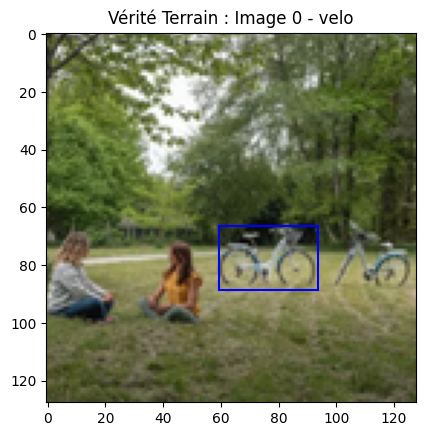

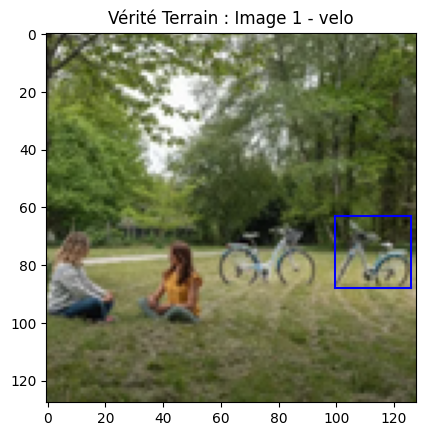

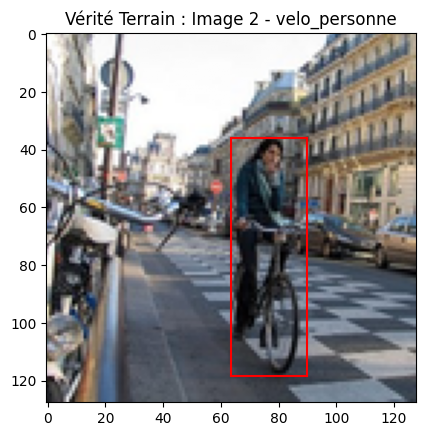

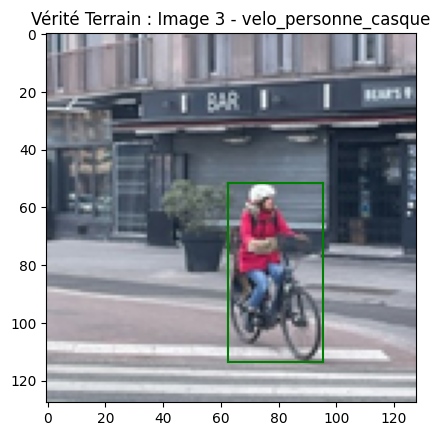

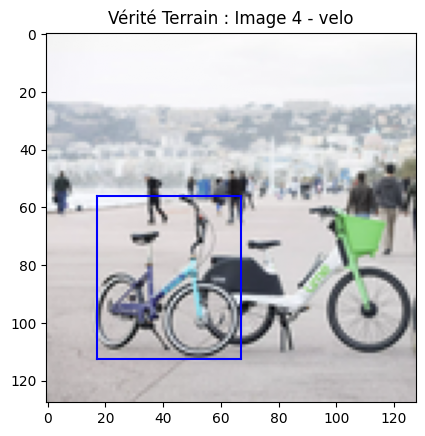

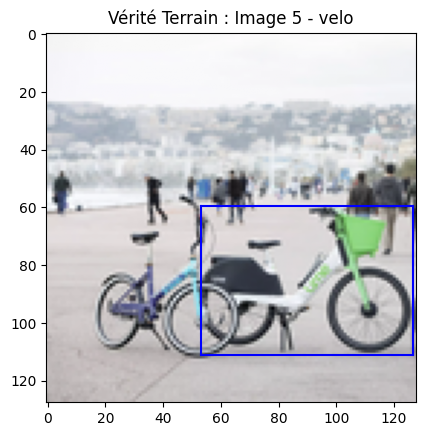

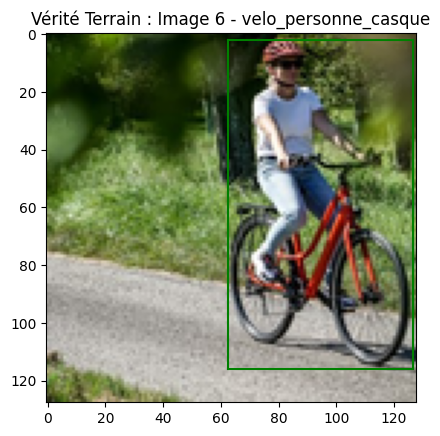

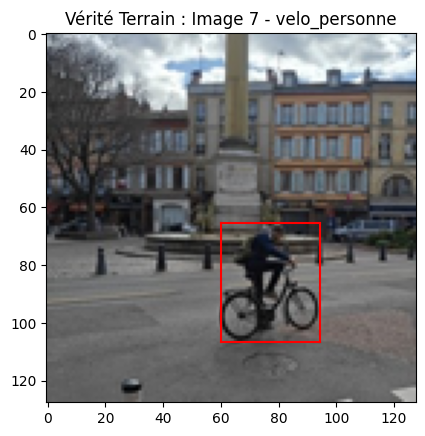

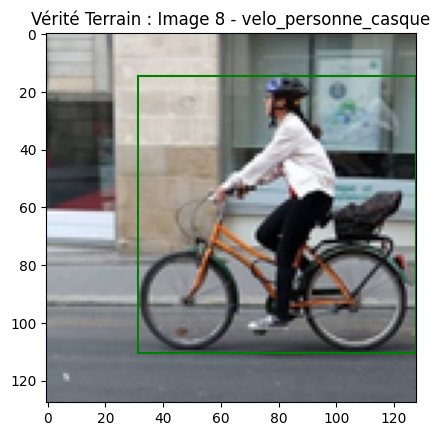

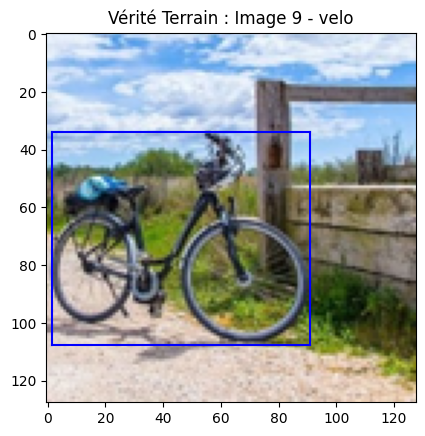

In [14]:
# Si seuls x et y sont indiqués, on tire au hasard un numéro d'image et on affiche le label y associé  à l'image
# Si un 2e y, nommé y_pred, est indiqué, alors les deux labels sont affichés côte à côte, afin de pouvoir les comparer
# Enfin on peut également indiquer l'id de l'image que l'on souhaite visualiser.
def print_data_localisation(x, y, y_pred=[], id=None, image_size=64):
  if id==None:
    # Tirage aléatoire d'une image dans la base
    num_img = np.random.randint(x.shape[0]-1)
  else:
    num_img = id

  img = x[num_img]
  lab = y[num_img]

  colors = ["blue", "red", "green", "yellow"] # Différentes couleurs pour les différentes classes
  classes = ['velo', 'velo_personne', 'velo_personne_casque', 'rien']

  if np.any(y_pred):
    plt.subplot(1, 2, 1)

  # Affichage de l'image
  plt.imshow(img)
  # Détermination de la classe
  class_id = np.argmax(lab[5:])

  # Détermination des coordonnées de la boîte englobante dans le repère image
  ax = (lab[1]*y_std[1] + y_mean[1]) * image_size
  ay = (lab[2]*y_std[2] + y_mean[2]) * image_size
  width = (lab[3]*y_std[3] + y_mean[3]) * image_size
  height = (lab[4]*y_std[4] + y_mean[4]) * image_size
  #print("x: {}, y: {}, w: {}, h:{}".format(ax,ay,width, height))
  # Détermination des extrema de la boîte englobante
  p_x = [ax-width/2, ax+width/2]
  p_y = [ay-height/2, ay+height/2]
  # Affichage de la boîte englobante, dans la bonne couleur
  plt.plot([p_x[0], p_x[0]],p_y,color=colors[class_id])
  plt.plot([p_x[1], p_x[1]],p_y,color=colors[class_id])
  plt.plot(p_x,[p_y[0],p_y[0]],color=colors[class_id])
  plt.plot(p_x,[p_y[1],p_y[1]],color=colors[class_id])
  plt.title("Vérité Terrain : Image {} - {}".format(num_img, classes[class_id]))

  if np.any(y_pred):
    plt.subplot(1, 2, 2)
    # Affichage de l'image
    plt.imshow(img)
    lab = y_pred[num_img]
    # Détermination de la classe
    class_id = np.argmax(lab[5:])

    # Détermination des coordonnées de la boîte englobante dans le repère image
    ax = (lab[1]*y_std[1] + y_mean[1]) * image_size
    ay = (lab[2]*y_std[2] + y_mean[2]) * image_size
    width = (lab[3]*y_std[3] + y_mean[3]) * image_size
    height = (lab[4]*y_std[4] + y_mean[4]) * image_size
    #print("x: {}, y: {}, w: {}, h:{}".format(ax,ay,width, height))
    # Détermination des extrema de la boîte englobante
    p_x = [ax-width/2, ax+width/2]
    p_y = [ay-height/2, ay+height/2]
    # Affichage de la boîte englobante, dans la bonne couleur
    plt.plot([p_x[0], p_x[0]],p_y,color=colors[class_id])
    plt.plot([p_x[1], p_x[1]],p_y,color=colors[class_id])
    plt.plot(p_x,[p_y[0],p_y[0]],color=colors[class_id])
    plt.plot(p_x,[p_y[1],p_y[1]],color=colors[class_id])
    plt.title("Prédiction : Image {} - {}".format(num_img, classes[class_id]))

  plt.show()

for i in range(10):#x.shape[0]):
    print_data_localisation(x_train, y_train, image_size=IMAGE_SIZE, id=i)


Fonction d'affichage des courbes d'apprentissage et de validation

In [15]:
def plot_training_analysis(history, metric='loss'):

  loss = history.history[metric]
  val_loss = history.history['val_' + metric]

  epochs = range(len(loss))

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training ' + metric)
  plt.plot(epochs, val_loss, 'g', label='Validation ' + metric)
  plt.title('Training and validation ' + metric)
  plt.legend()

  plt.show()

Num GPUs Available:  1
Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - classes_accuracy: 0.3122 - classes_loss: 40.1429 - coord_iou: 0.1949 - coord_loss: 4.7018 - loss: 46.7113 - p_accuracy: 0.9293 - p_loss: 1.8589 - val_classes_accuracy: 0.3509 - val_classes_loss: 18.2463 - val_coord_iou: 0.3767 - val_coord_loss: 1.0006 - val_loss: 19.7726 - val_p_accuracy: 1.0000 - val_p_loss: 0.0312
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - classes_accuracy: 0.5220 - classes_loss: 17.2572 - coord_iou: 0.3880 - coord_loss: 0.9141 - loss: 18.2035 - p_accuracy: 1.0000 - p_loss: 0.0272 - val_classes_accuracy: 0.4649 - val_classes_loss: 17.8102 - val_coord_iou: 0.3836 - val_coord_loss: 0.9330 - val_loss: 19.2223 - val_p_accuracy: 1.0000 - val_p_loss: 0.0046
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - classes_accuracy: 0.6713 - classes_loss: 14.1639 - coord_iou: 0.3866 - coord_loss: 0.8108 - loss: 14.9833 - p_accuracy: 1.0000 - p_loss: 0.0040 - val_classes_accuracy: 0.4518 - val_

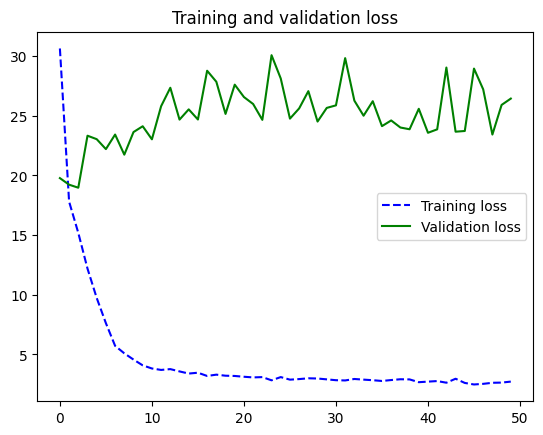

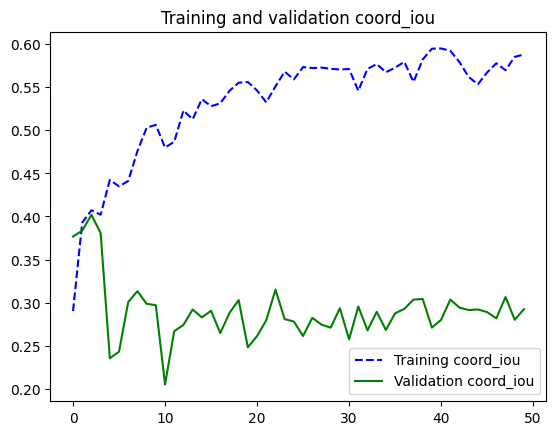

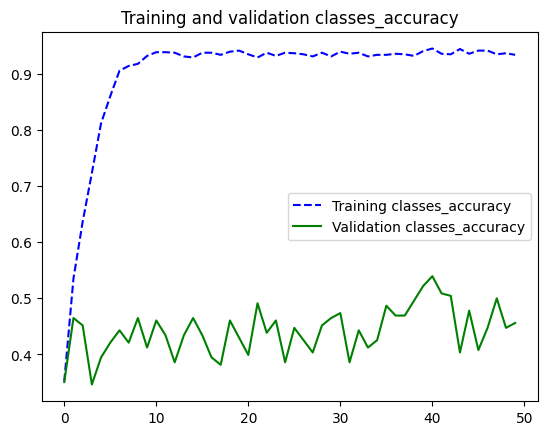

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step


<ipython-input-16-dc7b67da3191>:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[i, 0] = y_pred_presence[i]


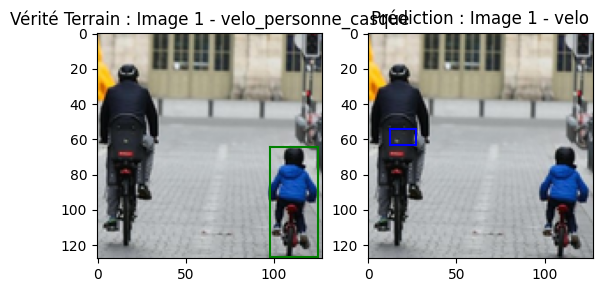

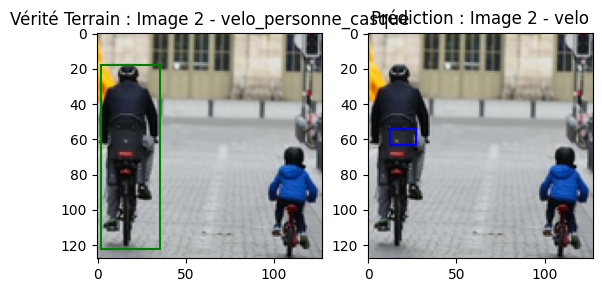

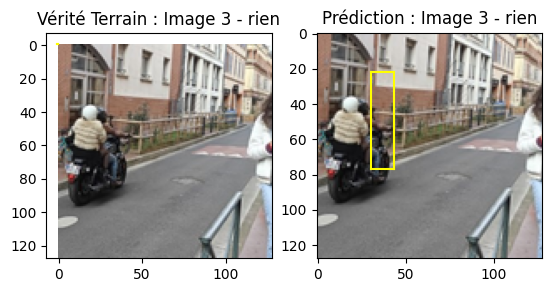

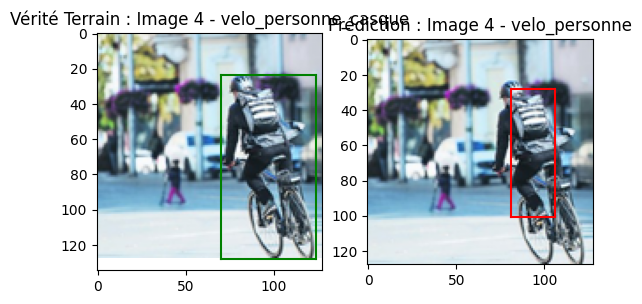

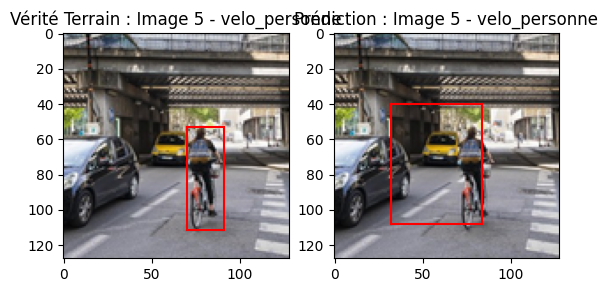

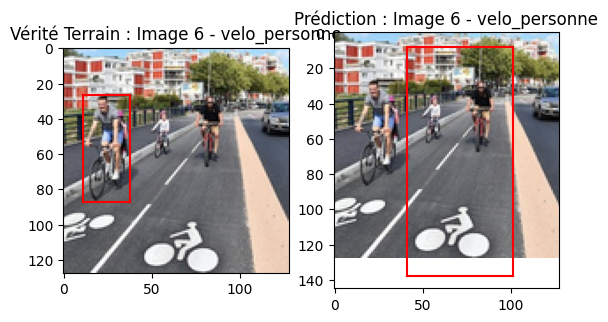

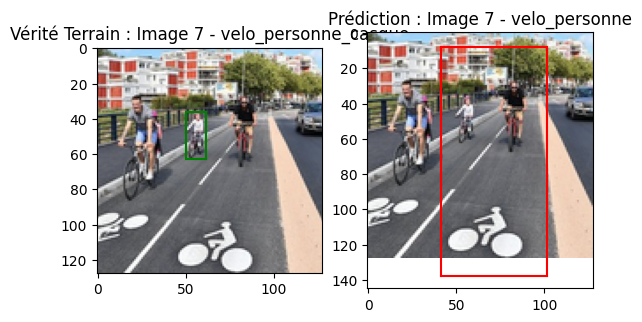

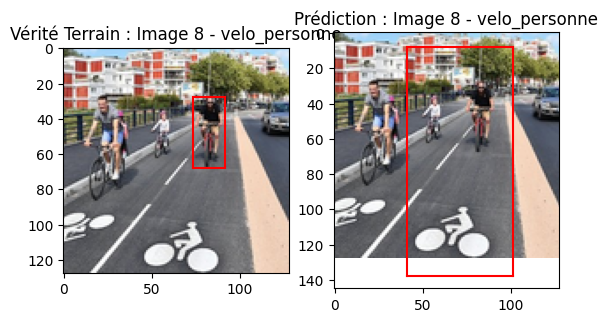

La précision globale est de 12.2%

------------------------------------------
| Classe | Précision | Rappel | F1-score |
------------------------------------------
| velo   |   0.12    |  0.09  |   0.10   |
------------------------------------------
| velo_personne|   0.08    |  0.12  |   0.10   |
------------------------------------------
| velo_personne_casque|   0.17    |  0.15  |   0.16   |
------------------------------------------
| rien   |   0.25    |  0.12  |   0.17   |
------------------------------------------


In [16]:
def create_model_localisation(input_shape=(128, 128, 3)):

  input_layer = Input(shape=input_shape)

  conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input_layer)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

  conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

  conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

  # Cette couche vectorise le tenseur de sortie de votre base convolutive, et
  # constituera l'entrée des 3 couches de sortie ci-dessous
  prev_layer = Flatten()(pool3)

  #### Couches de sortie A COMPLETER
  output_p = Dense(1, activation='sigmoid', name='p')(prev_layer)   # Sortie caractérisant la présence d'un objet
  output_coord = Dense(4, activation='linear', name='coord')(prev_layer) # Sortie caractérisant les coordonnées de boîte englobante
  output_class = Dense(4, activation='softmax', name='classes')(prev_layer) # Sortie caractérisant les probabilités de classe

  output= [output_p, output_coord, output_class]
  model = Model(input_layer, output)

  return model

def entropie_croisee(y_true, y_pred):
  return -tf.reduce_sum(y_true * tf.math.log(y_pred + 1e-6))

def mse(y_true, y_pred):
  return tf.reduce_mean(tf.square(y_true - y_pred))

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

batch_size=16
model = create_model_localisation()
opt = Adam(learning_rate=3e-4)

loss = [entropie_croisee, mse, entropie_croisee]
metrics =[ ['accuracy'], [iou()], ['accuracy']]
loss_weights = [1.0, 1.0, 1.0]

model.compile(loss=loss,
              optimizer=opt,
              metrics=metrics,
              loss_weights=loss_weights
              )
history = model.fit(x_train, [y_train[:,0], y_train[:,1:5], y_train[:,5:]],
              epochs=50,
              batch_size=batch_size,
              validation_data=(x_val, [y_val[:,0], y_val[:,1:5], y_val[:,5:]]))

# Analyse des résultats : courbes d'évolution de la fonction de perte, et de l'IoU des boîtes englobantes ainsi que de la précision des classes prédites
plot_training_analysis(history, metric='loss')
plot_training_analysis(history, metric='coord_iou')
plot_training_analysis(history, metric='classes_accuracy')

# Prédiction des données de test
y_pred_presence, y_pred_coords, y_pred_classes = model.predict(x_test)
y_pred = np.zeros(y_test.shape)
for i in range(y_pred.shape[0]):
  y_pred[i, 0] = y_pred_presence[i]
  y_pred[i, 1:5] = y_pred_coords[i]
  y_pred[i, 5:] = y_pred_classes[i]

# Affichage des résultats sur plusieurs images
print_data_localisation(x_test, y_test, y_pred = y_pred, id=1, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=2, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=3, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=4, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=5, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=6, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=7, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=8, image_size=IMAGE_SIZE)


class_res, accuracy = global_accuracy(y_test, y_pred, iou_thres=0.4)

print(f"La précision globale est de {accuracy:.1f}%")

print()
print("------------------------------------------")
print("| Classe | Précision | Rappel | F1-score |")
print("------------------------------------------")
for i in range(num_classes):
  print(f"| {class_labels[i]:7s}|   {class_res[i]['Precision']:.2f}    |  {class_res[i]['Rappel']:.2f}  |   {class_res[i]['F-score']:.2f}   |")
  print("------------------------------------------")